### Preliminaries

In [3]:
# Load required packages
using Plots, Statistics, Distributions, Random
Random.seed!(2359112412)

TaskLocalRNG()

# Exercise 7.4
The asymptotic variances derived from Exercise 5.10 are given by
$$ Avar(\hat{\theta}_n) = \frac{\theta^2}{n}$$
and
$$ Avar(\tilde{\theta}_n) = \frac{5}{4n}\theta^2 .$$
Here Avar denotes the variance of the limiting distribution scaled by $\sqrt{n}$. The first is just the standard (asymptotic) variance of the sample mean while the asymptotic variance of $\tilde{\theta}_n$ can be derived using the asymptotic distribution of $\frac{1}{n} \sum_{i = 1}^N X_i^2$ and the delta method.

// TODO check these variances empirically

In [4]:
# Functions for θ and avar estimators
θ_hat(x) = mean(x)
θ_tilde(x) = sqrt(0.5 * (1/length(x)) * sum(x.^2))

se_hat(x) = sqrt(θ_hat(x)^2 / length(x))
se_tilde(x) = sqrt((5/4) * length(x)^-1 * θ_tilde(x)^2)

# Function to simulate estimators given some (true) θ
function simulate_estimators(n, reps, θ)

    θ_hats = zeros(reps)
    θ_tildes = zeros(reps)
    se_hats = zeros(reps)
    se_tildes = zeros(reps)

    for i in 1:reps
        sample = rand(Exponential(θ), n)
        θ_hats[i] = θ_hat(sample)
        θ_tildes[i] = θ_tilde(sample)
        se_hats[i] = se_hat(sample)
        se_tildes[i] = se_tilde(sample)
    end

    return (θ_hats = θ_hats, θ_tildes = θ_tildes, se_hats = se_hats, 
        se_tildes = se_tildes)
end

# Function for calculating (empirical) rejection probabilities
function calculate_rej_prob(estimates, ses, α; θ = 2)
    t = @. (estimates - θ) / ses
    reject = abs.(t) .> quantile.(Normal(), 1 - α/2) 
    return mean(reject)
end

# Final function that simulates rejection probability given θ
function simulate_β(θ; α = 0.05, n = 10000, reps = 10000)
    if θ < 0 throw(DomainError(θ, "θ must be strictly positive")) end
    θ_hats, θ_tildes, ses_hats, ses_tildes = simulate_estimators(n, reps, θ)

    β_hat = calculate_rej_prob(θ_hats, ses_hats, α)
    β_tilde = calculate_rej_prob(θ_tildes, ses_tildes, α)

    return (β_hat = β_hat, β_tilde = β_tilde)
end

simulate_β (generic function with 1 method)


Next we plot the power function for a sample of $N = 100$ and a range of $\theta$ values.

In [16]:
θ_grid = range(0.5, 4, 100);

results25 = [simulate_β(θ; n = 25) for θ in θ_grid];
results100 = [simulate_β(θ; n = 100) for θ in θ_grid];
results1000 = [simulate_β(θ; n = 1000) for θ in θ_grid];

β_hat25, β_tilde25 = [getindex.(results25, i) for i in 1:2];
β_hat100, β_tilde100 = [getindex.(results100, i) for i in 1:2];
β_hat1000, β_tilde1000 = [getindex.(results1000, i) for i in 1:2];


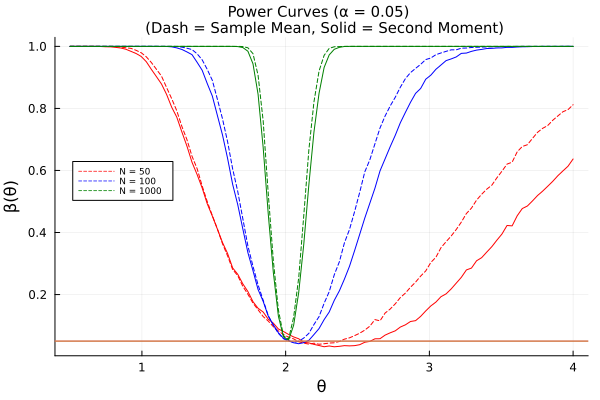

In [45]:

plot(θ_grid, β_hat25, linestyle =:dash, color =:red, label = "N = 50")
plot!(θ_grid, β_tilde25, color =:red, label =:none)

plot!(θ_grid, β_hat100, linestyle =:dash, color =:blue, label = "N = 100")
plot!(θ_grid, β_tilde100, color =:blue, label =:none)

plot!(θ_grid, β_hat1000, linestyle =:dash, color =:green, label = "N = 1000")
plot!(θ_grid, β_tilde1000, color =:green, label =:none)

plot!(xlabel = "θ", ylabel = "β(θ)")
plot!(title = "Power Curves (α = 0.05) \n (Dash = Sample Mean, Solid = Second Moment)", titlefontsize=:10)
plot!(subtitle = "test")
plot!(legend=:left, legend_font_pointsize=:6)
hline!([0.05 0.05], label =:none)

The plot illustrates a few things:
- Size $\alpha = 0.05$: The test should have an asymptotic size of 0.05 because it is based on the limit distributions of the estimators (i.e. we use critical values from a Standard Normal). We can see this does not quite hold in a smaller sample of size 50 (we reject slightly to often looking at the orange line indicating 0.05 at $\theta=2$), but this is already fairly accurate with N = 100 and we can see no difference with N = 1000.
- Non-symmetry: For small sample sizes where the approximation does not hold the power curves are shifted to the right and have a higher (absolute) slope to the left of the minimum. This probably results from the right-skewness of the Exponential/the resulting right-skewness of the distribution of the estimators in finite samples.  
- Test 1 dominates Test 2: The test based on the sample mean has uniformly higher power which probably reflects the smaller asymptotic variance. The difference is more pronounced for smaller samples but vanishes in the limit (both estimators are consistent), which probably results from a lower rate of convergence (in distribution) of the second estimator (my guess is the squaring makes the skewness matter more).
- Consistency: For N = 1000 we can already see $\beta(\theta) \to 1$ even for values close to $\theta =2$ (but not equal).
- We could construct test-statistics that are exact in finite samples using that the sum of Exponential r.v.s (and thus the sample mean) follows a Gamma distribution.